In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import akita_utils_forplotting as utils
import numpy as np
import pandas as pd
import sys, os, psutil, time 
import matplotlib.pyplot as plt
import pysam



#from optparse import OptionParser


nt = ['A', 'T', 'C', 'G']

In [3]:
print(utils.hic_params)

[{'name': 'one_to_two', 'operation': 'mean'}, {'name': 'concat_dist_2d'}, {'name': 'conv_block_2d', 'filters': 48, 'kernel_size': 3}, {'name': 'symmetrize_2d'}, {'name': 'dilated_residual_2d', 'filters': 24, 'kernel_size': 3, 'rate_mult': 1.75, 'repeat': 6, 'dropout': 0.1}, {'name': 'cropping_2d', 'cropping': 32}, {'name': 'upper_tri', 'diagonal_offset': 2}, {'name': 'final', 'units': 5, 'activation': 'linear'}]


In [4]:
utils.get_bin(2500)

-30

In [5]:
print(utils.target_length)

512


In [17]:
utils.target_length_cropped

448

In [7]:
#REMEMBER!!!!!!! +1MB SEQUENCE GOES IN, BUT MAKES PREDICTION FOR 917504BP
#1MB CORRESPONDS TO 512, 2048 BP BINS THAT GETS CUT DOWN TO 448 BINS 

In [8]:
#TOTAL AKITA INPUT LENGTH 

akita_seq_len=1048576

#HG38 REF FA
hg38_file = '/pollard/home/shzhang/akita/run_akita/refs/hg38.fa'
fasta_hg38 = pysam.Fastafile(hg38_file)

#GENCODE
gene_annot = pd.read_csv('/pollard/data/genetics/GENCODE/release32/gencode.v32.genes_only.bed', sep = '\t', names = ['CHROM', 'start_gene', 'end_gene', 'Gene'])
gene_annot[gene_annot.CHROM != 'chrM']
gene_annot.head()

,CHROM,start_gene,end_gene,Gene
0,chr1,11869,14409,DDX11L1
1,chr1,14404,29570,WASH7P
2,chr1,17369,17436,MIR6859-1
3,chr1,29554,31109,MIR1302-2HG
4,chr1,30366,30503,MIR1302-2


In [9]:
gene_annot['span']=gene_annot.end_gene-gene_annot.start_gene
np.median(gene_annot.span)
#plt.hist(gene_annot['span'], bins=100)
#plt.show()

3597.0

In [70]:
#data directories
date = '20230726'
d='/pollard/home/shzhang/akita_variant_scoring/akdemir_collab/'
data_dir = d + 'data/'
fig_dir = d + 'figs/' + date + '/'

#two folders are colab_fasta and new_fasta

In [11]:
#! ls /pollard/home/shzhang/akita_variant_scoring/akdemir_collab/data/new_fasta/walks.bed

In [93]:
#write separate plotting function so this isn't too messy
#for plotting post akita predictions 

def plot_complex_pred(ALT_mat, REF_mat, ALT_label, REF_label, gene_length):
    print('plotting ' + ALT_label)
    
    #add an option to get bins of gene boundaries based on the gene size 
    bin_start=utils.get_bin(utils.half_patch_size - round(gene_length/2))
    bin_end=utils.get_bin(utils.half_patch_size + round(gene_length/2))
     
    plt.figure(figsize=(8,4))
    target_index = 0
    vmin=-2; vmax=2

    plt.subplot(121) 
    im = plt.matshow(ALT_mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.axvline(x = bin_start, color = 'b', linestyle = '--', linewidth=1, label = 'gene start')
    plt.axvline(x = bin_end, color = 'b', linestyle='--', linewidth=1, label = 'gene end')
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    #plt.title('ALT Prediction' + '\n' + '{} at {}:{}-{}'.format(SVTYPE, CHR, POS, END),y=1.15 )
    plt.title('ALT Prediction: \n ' + ALT_label, y=1.15)

    plt.subplot(122) 
    im = plt.matshow(REF_mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.axvline(x = bin_start, color = 'b', linestyle='--', linewidth=1, label = 'gene start')
    plt.axvline(x = bin_end, color = 'b', linestyle='--', linewidth=1, label = 'gene end')
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('REF Prediction' + '\n' + REF_label, y=1.15 )
    

    plt.tight_layout()
    plt.savefig('{}{}_{}.pdf'.format(fig_dir, date, ALT_label), dpi=300)   # save the figure to file
    plt.close('all')

In [67]:
def read_fasta(fa):
    '''
    read in fasta file and return sequence only 
    '''
    
    seq=''
    with open(fa, "r") as fa_file:
        for line in fa_file:
            if not (line.startswith('>')):
                seq += line.strip()
    fa_file.close()
                
    return(seq)
    

In [68]:
fasta_hg38.fetch('chr1', 0, 10).upper()

'NNNNNNNNNN'

In [95]:
#make akita predictions for each walk and plot 
for i in os.listdir(data_dir + 'new_fasta/walks.fasta'):
    #print(i)
    bed_name=i[:-3] +'.bed'
    name_parts = i.rsplit('_', 2)

    gencode_coord=gene_annot[gene_annot.Gene == name_parts[1]]    
    gene_len=abs(gencode_coord.end_gene-gencode_coord.start_gene)
    gene_mid_coord=np.floor(gencode_coord.start_gene + (gene_len/2))
    #print('gene mid coord', gene_mid_coord)
    #print('gencode coord', gencode_coord)
    
    #read in bed file and figure out where to center the file 
    bed=pd.read_csv(data_dir+ 'new_fasta/walks.bed/' + bed_name, sep='\t', header=None)
    #rename columns
    bed.columns = ['chr', 'start', 'end', 'strand', '4', '5']
    bed['chr'] = bed['chr'].astype('str') 
    #get spans of each walk 
    bed['span']=abs(bed['end']-bed['start']) 
    #print(bed)
    
    #print('bed span', np.sum(bed['span']))


    #get the row where gene_mid_coord 
    #print(gencode_coord['CHROM'])
    condition = ((bed['chr']==gencode_coord.CHROM.values[0])
                & (bed['start'] <= int(gene_mid_coord)) & (int(gene_mid_coord) <= bed['end']) ) 

    #pd.set_option('display.max_rows', None)
    #print('condition', condition.index[condition])
    #in cases where the middle of the gene shows up more than once, just takes first instance 
    row_midgene = (condition.index[condition].tolist())[0]

    #print('row_midgene index', row_midgene)
        
        

    #get span for the entire walk up to the middle of the gene 
    bed_row=bed.iloc[row_midgene, :]
    #print('bed_Row', bed_row)
    #print('gene row span', np.sum(bed_row['span']))
    #print('gene_mid_Coord', gene_mid_coord)
    if row_midgene>0:
        bed_begin=bed.iloc[0:row_midgene, :]
        #print('bed_begin', bed_begin)
        first_half_span=(np.sum(bed_begin['span'])) + int(gene_mid_coord-bed_row['start'])
        bed_before=pd.concat([bed_begin, bed_row])

    else:
        first_half_span=int(gene_mid_coord-bed_row['start'])
        bed_before=bed_row
    #print('bed_before', bed_row)
            
    #then, get span for entire walk from middle of gene to end 
    if row_midgene<(len(bed)-1):
        bed_end=bed.iloc[(row_midgene+1):len(bed), :]
        #print('bed_end', bed_end)
        second_half_span=(np.sum(bed_end['span'])) + int(bed_row['end']-gene_mid_coord)
    else:
        second_half_span=int(bed_row['end']-gene_mid_coord)
        

        
    #print('first_half_span', first_half_span)
    #print('second half span', second_half_span)
        
    try:
        
        #read in fasta file 
        seq=read_fasta(data_dir + 'new_fasta/walks.fasta/' + i)
        
        
        #define start and end coordinates of reference matrices
        #currently, just centered around the middle of the gene of interest
        
        CHR = gencode_coord.CHROM.values[0]
        POS = int(gene_mid_coord-utils.half_patch_size)
        END= int(POS+utils.seq_length)
        REF_seq = fasta_hg38.fetch(CHR, POS, END).upper()
     
    
        #define ALT from fasta sequences given to us       
        #check length of walk start to middle of gene, must be at lesat half of akita_seq_len
        mid_seq_idx=0
        if first_half_span>=(utils.half_patch_size):
        
            #get start of ALT sequence 
            ALT_L_start=first_half_span-(utils.half_patch_size)
            ALT_seq_left=seq[ALT_L_start:(ALT_L_start + utils.half_patch_size)]
            mid_seq_idx=(ALT_L_start + utils.half_patch_size)
        else:
            
            #get remainder of sequence from reference
            pad_REF_len=utils.half_patch_size-first_half_span            
            left_REF_pad = fasta_hg38.fetch(bed_row['chr'], bed_row['start']-pad_REF_len, bed_row['start']).upper()
            
            ALT_seq_left=left_REF_pad + seq[0:first_half_span]
            mid_seq_idx=first_half_span
        
        
        if second_half_span>=(utils.half_patch_size):
            #print('alt l start', ALT_L_start)
            ALT_seq_right=seq[mid_seq_idx:(mid_seq_idx + utils.half_patch_size)]
            #print('ALT SEQ RIGHT LEN', len(ALT_seq_right))
                
        else:
            pad_REF_len=utils.half_patch_size-second_half_span            
            right_REF_pad = fasta_hg38.fetch(bed_row['chr'], bed_row['end'], bed_row['end'] + pad_REF_len).upper()
            
            ALT_seq_right=seq[mid_seq_idx:len(seq)] + right_REF_pad
        
        
        #print('ALT SEQ LEFT' , len(ALT_seq_left))
        #print('ALT SEQ RIGHT' , len(ALT_seq_right))
        
        ALT_seq=ALT_seq_left + ALT_seq_right
            
        ####################
        
        assert len(REF_seq) == utils.seq_length, 'REF_seq is not right length'
        assert len(ALT_seq) == utils.seq_length, 'ALT_seq is not right length'
        #print(REF_seq[1:10])
        #print(ALT_seq[1:10])
    
        #this is where akita is actually run, output vector size is (99681,)
        REF_vector, ALT_vector = utils.vector_from_seq(REF_seq), utils.vector_from_seq(ALT_seq)
        REF_mat, ALT_mat = utils.mat_from_vector(REF_vector), utils.mat_from_vector(ALT_vector)
            
        #NOW, PLOT! AND SAVE! 
        ALT_label=i[:-3]
        REF_label='{}:{}-{}'.format(CHR, POS, END)
        plot_complex_pred(ALT_mat, REF_mat, ALT_label, REF_label, gene_len)
            
        
    except:
        #for the input sequences where first half is less than 0.5 Mb, will need to pad the ends 
        #i think we will just assume that we can pull from ref both before and after? 
        #print(i + ' is less than 1Mb in length, will deal with later ')
        
        
        print('error!!!! in file ', i )
        
        
        #if gene center is too close to left or right of chromosome, will throw an error 
            
        #check that total walk length is at least 1Mb
        #if np.sum(bed['span']>akita_seq_len):

plotting SMF-12-12_walk_4_KRAS_containing
plotting SMF-12-12_walk_5_MDM2_containing
plotting SMF-12-7_walk_4_SKI_containing
plotting SMF-12-9_walk_4_MOS_containing
plotting SMF-12-15_walk_10_MYC_containing
plotting SMF-12-23_walk_11_GLI1_containing
plotting SMF-12-16_walk_5_MCF2_containing
plotting SMF-12-15_walk_6_MYC_containing
plotting SMF-12-17_walk_9_MDM2_containing
plotting SMF-12-23_walk_8_MDM2_containing
plotting SMF-12-12_walk_3_KRAS_containing
plotting SMF-12-12_walk_2_MDM2_containing
plotting SMF-12-17_walk_5_MDM2_containing
plotting SMF-12-12_walk_7_MDM2_containing
plotting SMF-12-7_walk_5_SKI_containing
plotting SMF-12-23_walk_11_MDM2_containing
plotting SMF-12-12_walk_5_GLI1_containing
plotting SMF-12-15_walk_7_MYC_containing
plotting SMF-12-17_walk_5_GLI1_containing
plotting SMF-12-17_walk_7_MDM2_containing
plotting SMF-12-18_walk_2_TCF3_containing
plotting SMF-12-18_walk_5_MDM2_containing
plotting SMF-12-17_walk_4_GLI1_containing
plotting SMF-12-14_walk_10_MYC_containin

In [42]:
#for the reference, could make prediction for each individual region
#but for some of these walks, could be 50-100 predictions for each sample
#one option is to get start and end of total walk region, make as few akita predictions as possible, 
#cut out relevant ones and stitch it together -- is prediction accurate? my guess is yes because it's all reference,
#but also previously mentioned that 1bp changes can make a big difference 

AGCTGGGTTC


In [43]:
#i think problem is that centering the gene for some of them, that walk is already 1Mb so the predictions are the same 

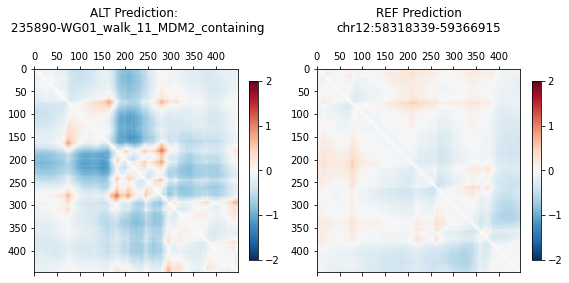